In [1]:
import math
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain,combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
import ast
import seaborn as sns
from tqdm import tqdm


In [2]:
from Nash import find_nash_equilibria_v2
from Functions import compute_and_visualize_shapley_values

# HuGa DB 

In [3]:
train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv" # Adjust the path as needed
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv" # Adjust the path as needed

### Creating Global Train set and Test set

In [4]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


#### Centrelized Training

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[11465   221     0     1    51     3   780]
 [  175 11728     0     1    68     2   782]
 [    1     0  7552    21     0    20     1]
 [    0     0    46  1862    26     2     0]
 [   24    28     3    64 26401    52    98]
 [    1     7    70     1   124  2158     1]
 [ 1051   846     0     1   105     0 36458]]


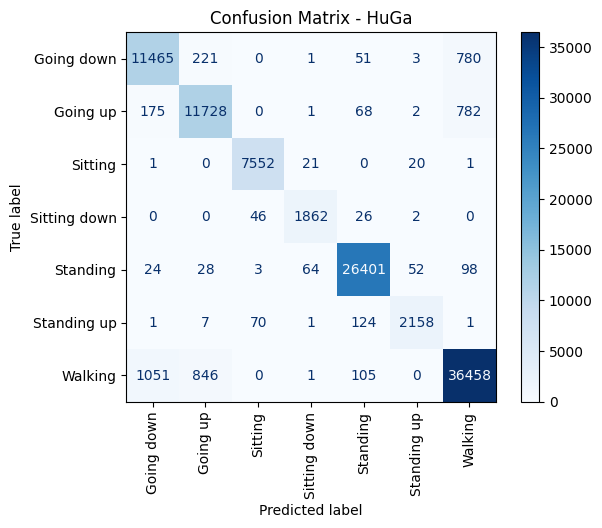

100%|██████████| 1/1 [00:11<00:00, 11.03s/it]

Trial 1/1 - Global test accuracy: 0.9542819718282324


In [13]:
# Parameters
n_trials = 1
n_trees = 10
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []


for trial in tqdm(range(n_trials)):
    

    model = RandomForestClassifier(n_estimators=n_trees, random_state=42 + trial)
    model.fit(X_train_global, y_train_global)
    

    y_pred = model.predict(X_test_global)
    acc_test = accuracy_score(y_test_global, y_pred)
    

    cm = confusion_matrix(y_test_global, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - HuGa")
    plt.show()
    

    results_global.append(acc_test)
    
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")


df_global = pd.DataFrame(results_global, columns=["accuracy"])
df_global.to_csv("global.csv", index=False)


#### FL

In [5]:
# Define the DecisionTree class
class DecisionTree:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.tree_ = None
        self.random_state = random_state

    def fit(self, X, y):
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
        self.tree_.fit(X, y)

    def predict(self, X):
        return self.tree_.predict(X)

# Define the FederatedForest class
class FederatedForest:
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        predictions = np.array(predictions).T
        y = [np.bincount(row).argmax() for row in predictions]
        return np.array(y)
    

In [9]:
# Parameters
max_depth = 10
n_clients = 10 
n_trials = 1
random_seed = 42

results = []


for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the 10 clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []
    for i in range(n_clients):
        df_train_i = pd.read_csv(f"/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i+1:02d}.csv").dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_train, y_train)
        client_models.append(model)

        # Test locally
        df_test_i = pd.read_csv(f"/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i+1:02d}.csv").dropna(subset=['act'])
        X_test = df_test_i.drop('act', axis=1)
        y_test = label_encoder.transform(df_test_i['act'])

        # Evaluate globally
        y_pred_global = model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy
        y_pred_global = forest.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

df_results = pd.DataFrame(results)
df_results.to_csv("HuGa_results_with_FedFor.csv", index=False)


Trial 1/1


In [10]:
df_results = pd.read_csv("HuGa_results_with_FedFor.csv")

In [11]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
988,1,1111011101,"[1, 3, 4, 5, 7, 8, 9, 10]",0.883882,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
1020,1,1111111101,"[1, 3, 4, 5, 6, 7, 8, 9, 10]",0.882611,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
508,1,111111101,"[1, 3, 4, 5, 6, 7, 8, 9]",0.881956,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
956,1,1110111101,"[1, 3, 4, 5, 6, 8, 9, 10]",0.881604,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
1019,1,1111111100,"[3, 4, 5, 6, 7, 8, 9, 10]",0.881057,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258


In [12]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0000000001,1,[1],0.595840
1,0000000010,1,[2],0.518314
2,0000000100,1,[3],0.634129
3,0000100000,1,[6],0.658733
4,1000000000,1,[10],0.663258
5,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.880920


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.774655                  0.138337
4   Client 5        0.724177                  0.120265
6   Client 7        0.733238                  0.117134
8   Client 9        0.733981                  0.116225
3   Client 4        0.677110                  0.110752
9  Client 10        0.663258                  0.096475
2   Client 3        0.634129                  0.090085
5   Client 6        0.658733                  0.088291
0   Client 1        0.595840                  0.077774
1   Client 2        0.518314                  0.044663


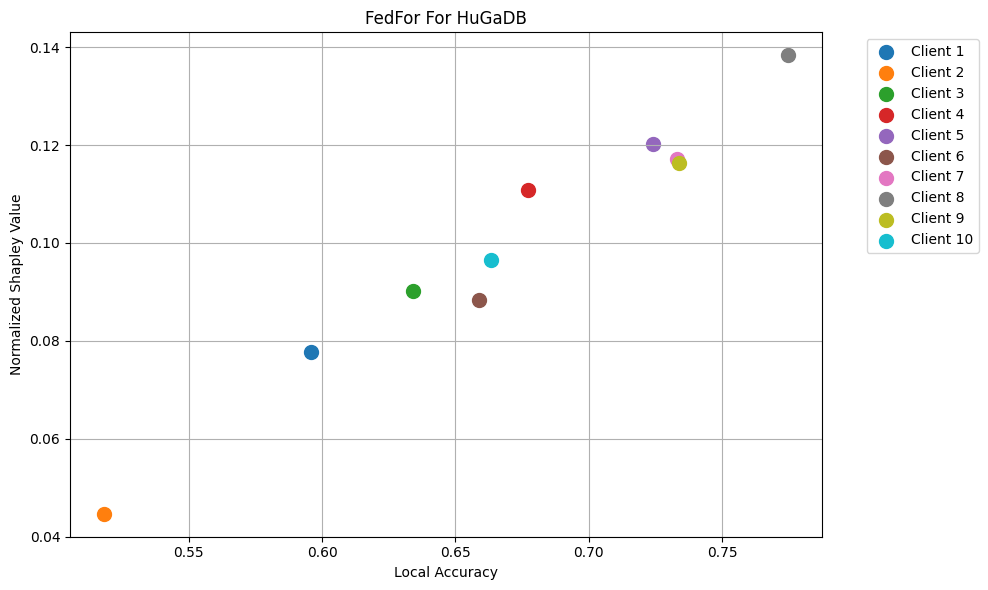

In [13]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="FedFor For HuGaDB",  
    print_df=True 
)


## Checking Nash For HuGa in Different subsample_ratios and Different max_depth

In [14]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [ ]:
# Parameters 
n_clients = 10
n_trials = 10
base_random_seed = 42
subsample_ratios = [0.6, 0.7, 0.8]    
max_depths = [10, 100]                                                  
random_seed = 42

# Containers to collect results across all parameter combinations
all_results = []                   
all_nash_equilibrium_counts = []   
all_nash_details = []             


for subsample_ratio in subsample_ratios:
    for max_depth in max_depths:
        print(f"\nRunning experiment with subsample_ratio = {subsample_ratio}, max_depth = {max_depth}")
        results = []
        nash_equilibrium_counts = Counter()
        nash_details_all = []  

        #  Run multiple trials 
        for trial in range(n_trials):
            print(f"  Trial {trial + 1}/{n_trials} for subsample_ratio={subsample_ratio}, max_depth={max_depth}")
            trial_seed = base_random_seed + trial
            random.seed(trial_seed)
            np.random.seed(trial_seed)

            #  Load and subsample global training data
            df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
            df_train_global = df_train_global.sample(frac=subsample_ratio, random_state=trial_seed).reset_index(drop=True)
            X_train_global = df_train_global.drop('act', axis=1)
            y_train_global = df_train_global['act']

            #  Load and subsample global testing data 
            df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
            df_test_global = df_test_global.sample(frac=subsample_ratio, random_state=trial_seed).reset_index(drop=True)
            X_test_global = df_test_global.drop('act', axis=1)
            y_test_global = df_test_global['act']

            #  Encode labels 
            label_encoder = LabelEncoder()
            y_train_global = label_encoder.fit_transform(y_train_global)
            y_test_global = label_encoder.transform(y_test_global)

            #  Scale features 
            scaler = StandardScaler()
            X_train_global_scaled = scaler.fit_transform(X_train_global)
            X_test_global_scaled = scaler.transform(X_test_global)

            #  Train models for each client 
            client_models = []
            client_global_accuracies = {}
            for i in range(n_clients):
                df_train_i = pd.read_csv(train_files_pattern.format(i=i+1)).dropna(subset=['act'])
                df_train_i = df_train_i.sample(frac=subsample_ratio, random_state=trial_seed).reset_index(drop=True)
                X_train = df_train_i.drop('act', axis=1)
                y_train = label_encoder.transform(df_train_i['act'])
                # Train a DecisionTree using max_depth
                model = DecisionTree(max_depth=max_depth, random_state=np.random.randint(0, 100000))
                model.fit(X_train, y_train)
                client_models.append(model)
                # Evaluate globally 
                y_pred_global = model.predict(X_test_global)
                acc_global = accuracy_score(y_test_global, y_pred_global)
                client_global_accuracies[i] = acc_global

            #Evaluate all coalitions 
            trial_results = []
            n_combinations = 2 ** n_clients
            for i in tqdm(range(1, n_combinations), desc=f"    Evaluating coalitions for trial {trial+1}"):
                bin_str = format(i, f'0{n_clients}b')
                client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
                included_models = [client_models[j] for j in client_indices]
                if not included_models:
                    continue

                # Aggregate models using FederatedForest
                forest = FederatedForest()
                for model in included_models:
                    forest.add_model(model)
                # Evaluate aggregated model 
                y_pred_global = forest.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)

                row = {
                    'Trial': trial + 1,
                    'Combination': bin_str,
                    'Clients': [j + 1 for j in client_indices],
                    'Global Accuracy': acc_global
                }
                for j in range(n_clients):
                    row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]
                trial_results.append(row)

            df_trial_results = pd.DataFrame(trial_results)
            df_trial_results.set_index('Combination', inplace=True)

            # Find Nash equilibria for this trial 
            nash_df = find_nash_equilibria_v2(df_trial_results.reset_index())
            for combination in nash_df['Combination']:
                nash_equilibrium_counts[combination] += 1

            # Compute Shapley values (without plotting) 
            shapley_df = compute_and_visualize_shapley_values(df_trial_results.reset_index(),
                                                              client_global_accuracies,
                                                              n_clients=n_clients,
                                                              plot=False)
            shapley_df['Trial'] = trial + 1


            for idx, nash_row in nash_df.iterrows():
                combination_bin = nash_row['Combination']
                client_indices = [j for j in range(n_clients) if combination_bin[n_clients - 1 - j] == '1']
                clients_list = [j + 1 for j in client_indices]
                detail_record = {}
                detail_record['Trial'] = trial + 1
                detail_record['Combination'] = combination_bin
                detail_record['Clients'] = ",".join(str(c) for c in clients_list)
                for client in range(1, n_clients + 1):
                    if client in clients_list:
                        detail_record[f'Client {client} Accuracy'] = client_global_accuracies[client - 1]
                        val = shapley_df.loc[shapley_df['Client'] == f'Client {client}', 'Normalized Shapley Value']
                        detail_record[f'Client {client} Shapley Value'] = val.values[0] if not val.empty else np.nan
                    else:
                        detail_record[f'Client {client} Accuracy'] = np.nan
                        detail_record[f'Client {client} Shapley Value'] = np.nan
                detail_record['Global Accuracy'] = nash_row['Global Accuracy']
                detail_record['Subsample Ratio'] = subsample_ratio
                detail_record['Max Depth'] = max_depth
                nash_details_all.append(detail_record)

            results.extend(trial_results)


        df_results = pd.DataFrame(results)
        df_results['Subsample Ratio'] = subsample_ratio
        df_results['Max Depth'] = max_depth
        all_results.append(df_results)

        df_nash_counts = pd.DataFrame(nash_equilibrium_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
        df_nash_counts['Subsample Ratio'] = subsample_ratio
        df_nash_counts['Max Depth'] = max_depth
        all_nash_equilibrium_counts.append(df_nash_counts)
        

        filename = f"Nash_Equilibrium_Counts_HuGaFedFor_subsample_{subsample_ratio}_max_depth_{max_depth}.csv"
        df_nash_counts.to_csv(filename, index=False)
        print(f"Nash equilibrium counts saved to {filename}")
        
        df_nash_details = pd.DataFrame(nash_details_all)
        all_nash_details.append(df_nash_details)


final_nash_counts_df = pd.concat(all_nash_equilibrium_counts, ignore_index=True)
final_nash_details_df = pd.concat(all_nash_details, ignore_index=True)

final_nash_counts_df.to_csv("Nash_Equilibrium_Counts.csv", index=False)
final_nash_details_df.to_csv("Nash_Equilibrium_Details_HuGaFedFor.csv", index=False)
print("Process complete. Results saved.")


Running experiment with subsample_ratio = 0.6, max_depth = 10
  Trial 1/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [00:53<00:00, 18.98it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.763233                  0.127601
6   Client 7        0.742510                  0.119704
4   Client 5        0.736775                  0.115992
8   Client 9        0.733077                  0.109028
3   Client 4        0.709601                  0.108777
2   Client 3        0.718496                  0.106825
5   Client 6        0.661996                  0.093173
0   Client 1        0.676920                  0.084874
9  Client 10        0.649354                  0.080384
1   Client 2        0.551425                  0.053642
  Trial 2/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [00:54<00:00, 18.89it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.768137                  0.131263
7   Client 8        0.747055                  0.129278
4   Client 5        0.751340                  0.125004
3   Client 4        0.727799                  0.120604
8   Client 9        0.687428                  0.104825
2   Client 3        0.654958                  0.088665
5   Client 6        0.644173                  0.085191
9  Client 10        0.629690                  0.081225
0   Client 1        0.592512                  0.074395
1   Client 2        0.547971                  0.059551
  Trial 3/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [00:54<00:00, 18.69it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.778612                  0.128431
4   Client 5        0.745687                  0.125603
7   Client 8        0.740196                  0.122041
8   Client 9        0.736221                  0.118606
3   Client 4        0.683681                  0.103663
2   Client 3        0.662974                  0.092074
5   Client 6        0.678174                  0.091702
9  Client 10        0.618514                  0.075625
0   Client 1        0.589629                  0.073020
1   Client 2        0.569769                  0.069235
  Trial 4/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [00:55<00:00, 18.54it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.756553                  0.124417
4   Client 5        0.740653                  0.122431
6   Client 7        0.751373                  0.119994
8   Client 9        0.726088                  0.114302
3   Client 4        0.702742                  0.107946
5   Client 6        0.723123                  0.102242
2   Client 3        0.690556                  0.101107
9  Client 10        0.623027                  0.071357
0   Client 1        0.590183                  0.071035
1   Client 2        0.579577                  0.065169
  Trial 5/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [00:55<00:00, 18.48it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.782294                  0.121454
7   Client 8        0.757791                  0.120537
5   Client 6        0.769994                  0.120388
3   Client 4        0.750265                  0.114048
4   Client 5        0.733028                  0.111257
2   Client 3        0.715156                  0.102484
8   Client 9        0.699174                  0.096412
9  Client 10        0.634398                  0.073051
1   Client 2        0.595722                  0.072068
0   Client 1        0.621316                  0.068302
  Trial 6/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [00:56<00:00, 18.13it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.784477                  0.135977
7   Client 8        0.753018                  0.128813
4   Client 5        0.718138                  0.111559
8   Client 9        0.711637                  0.104104
3   Client 4        0.678826                  0.101740
2   Client 3        0.677506                  0.095094
5   Client 6        0.650788                  0.090877
0   Client 1        0.619768                  0.085293
9  Client 10        0.619035                  0.078935
1   Client 2        0.587820                  0.067607
  Trial 7/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [00:56<00:00, 18.01it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.774132                  0.129100
5   Client 6        0.773203                  0.128833
4   Client 5        0.759616                  0.120623
6   Client 7        0.744318                  0.115430
3   Client 4        0.695606                  0.106399
8   Client 9        0.711996                  0.103575
2   Client 3        0.630423                  0.082408
9  Client 10        0.634643                  0.077774
0   Client 1        0.589743                  0.072575
1   Client 2        0.550675                  0.063283
  Trial 8/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [00:58<00:00, 17.53it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.790570                  0.143436
7   Client 8        0.751845                  0.130538
3   Client 4        0.723726                  0.120345
4   Client 5        0.693211                  0.113991
8   Client 9        0.726120                  0.111954
2   Client 3        0.671755                  0.094834
9  Client 10        0.645965                  0.088350
0   Client 1        0.555693                  0.070302
5   Client 6        0.585279                  0.067328
1   Client 2        0.535296                  0.058922
  Trial 9/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [00:58<00:00, 17.43it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.774719                  0.132671
6   Client 7        0.755543                  0.120531
2   Client 3        0.717160                  0.113048
4   Client 5        0.689203                  0.111707
3   Client 4        0.679086                  0.102953
8   Client 9        0.686141                  0.099138
5   Client 6        0.656001                  0.090346
1   Client 2        0.610026                  0.079106
9  Client 10        0.627670                  0.075806
0   Client 1        0.570519                  0.074694
  Trial 10/10 for subsample_ratio=0.6, max_depth=10


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [00:57<00:00, 17.94it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.771591                  0.124017
5   Client 6        0.776478                  0.123026
6   Client 7        0.768772                  0.122427
4   Client 5        0.745361                  0.117542
8   Client 9        0.737150                  0.107428
2   Client 3        0.718838                  0.102021
3   Client 4        0.615516                  0.080543
9  Client 10        0.636532                  0.078414
0   Client 1        0.616282                  0.073056
1   Client 2        0.546277                  0.071526
Nash equilibrium counts saved to Nash_Equilibrium_Counts_HuGaFedFor_subsample_0.6_max_depth_10.csv

Running experiment with subsample_ratio = 0.6, max_depth = 100
  Trial 1/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [01:01<00:00, 16.65it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.730617                  0.125453
6   Client 7        0.723041                  0.120905
7   Client 8        0.698425                  0.117009
3   Client 4        0.665678                  0.106082
2   Client 3        0.635930                  0.101454
5   Client 6        0.644711                  0.099988
8   Client 9        0.657337                  0.097331
0   Client 1        0.655040                  0.092960
9  Client 10        0.636907                  0.084748
1   Client 2        0.502696                  0.054070
  Trial 2/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [01:00<00:00, 16.93it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.759535                  0.130880
4   Client 5        0.741158                  0.126573
7   Client 8        0.712908                  0.119163
3   Client 4        0.692217                  0.107737
8   Client 9        0.674655                  0.104386
2   Client 3        0.667161                  0.092503
0   Client 1        0.633991                  0.090808
9  Client 10        0.634692                  0.087742
5   Client 6        0.639823                  0.087214
1   Client 2        0.487464                  0.052994
  Trial 3/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [00:59<00:00, 17.18it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.783760                  0.141322
8   Client 9        0.717437                  0.120090
4   Client 5        0.637689                  0.107221
3   Client 4        0.659096                  0.106410
7   Client 8        0.661459                  0.102796
5   Client 6        0.673401                  0.098677
2   Client 3        0.655610                  0.097420
9  Client 10        0.639058                  0.086367
0   Client 1        0.588912                  0.081506
1   Client 2        0.501491                  0.058192
  Trial 4/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [01:00<00:00, 17.04it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.730226                  0.122368
4   Client 5        0.710953                  0.116873
5   Client 6        0.734038                  0.114464
8   Client 9        0.713771                  0.114436
7   Client 8        0.674069                  0.103555
2   Client 3        0.677050                  0.102314
3   Client 4        0.628207                  0.096226
9  Client 10        0.663821                  0.092555
0   Client 1        0.591991                  0.068967
1   Client 2        0.551832                  0.068244
  Trial 5/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [01:00<00:00, 16.96it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.766426                  0.127296
5   Client 6        0.738388                  0.122031
4   Client 5        0.721103                  0.116925
3   Client 4        0.697024                  0.110452
7   Client 8        0.703915                  0.109871
2   Client 3        0.677783                  0.101156
8   Client 9        0.677001                  0.095772
9  Client 10        0.649452                  0.086532
0   Client 1        0.593718                  0.071028
1   Client 2        0.503250                  0.058937
  Trial 6/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [01:01<00:00, 16.71it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.762207                  0.140236
7   Client 8        0.675649                  0.120183
4   Client 5        0.700950                  0.116920
8   Client 9        0.682312                  0.109418
3   Client 4        0.656653                  0.107480
9  Client 10        0.664261                  0.101261
0   Client 1        0.618367                  0.087592
5   Client 6        0.599664                  0.087184
2   Client 3        0.586501                  0.075557
1   Client 2        0.465942                  0.054171
  Trial 7/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [00:58<00:00, 17.55it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.774621                  0.137582
6   Client 7        0.744074                  0.131128
5   Client 6        0.712810                  0.119562
7   Client 8        0.681693                  0.106608
3   Client 4        0.640377                  0.102688
8   Client 9        0.658999                  0.096473
9  Client 10        0.650951                  0.087905
2   Client 3        0.654111                  0.085813
0   Client 1        0.563090                  0.073024
1   Client 2        0.508464                  0.059216
  Trial 8/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [00:59<00:00, 17.21it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.797315                  0.153670
3   Client 4        0.698164                  0.118198
7   Client 8        0.678060                  0.112241
4   Client 5        0.679885                  0.110599
8   Client 9        0.684235                  0.105967
2   Client 3        0.668269                  0.102729
9  Client 10        0.653736                  0.093768
0   Client 1        0.572262                  0.075060
5   Client 6        0.574429                  0.069267
1   Client 2        0.501165                  0.058502
  Trial 9/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [00:59<00:00, 17.20it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.725176                  0.128703
6   Client 7        0.727000                  0.125745
7   Client 8        0.700608                  0.117901
5   Client 6        0.665418                  0.102434
2   Client 3        0.669034                  0.102366
8   Client 9        0.642414                  0.095280
9  Client 10        0.635229                  0.089096
3   Client 4        0.614017                  0.085654
1   Client 2        0.582656                  0.080515
0   Client 1        0.539271                  0.072306
  Trial 10/10 for subsample_ratio=0.6, max_depth=100


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [00:57<00:00, 17.67it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.758362                  0.131345
7   Client 8        0.719115                  0.118067
5   Client 6        0.715612                  0.117654
4   Client 5        0.701194                  0.112448
8   Client 9        0.697382                  0.105480
2   Client 3        0.697610                  0.103867
9  Client 10        0.637901                  0.086621
3   Client 4        0.608152                  0.086615
0   Client 1        0.600121                  0.077509
1   Client 2        0.496571                  0.060393
Nash equilibrium counts saved to Nash_Equilibrium_Counts_HuGaFedFor_subsample_0.6_max_depth_100.csv

Running experiment with subsample_ratio = 0.7, max_depth = 10
  Trial 1/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [01:04<00:00, 15.76it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.768485                  0.128120
4   Client 5        0.757370                  0.121843
3   Client 4        0.740626                  0.119262
6   Client 7        0.736786                  0.110201
2   Client 3        0.714192                  0.102572
8   Client 9        0.704724                  0.094585
5   Client 6        0.654048                  0.089724
0   Client 1        0.609920                  0.087163
9  Client 10        0.637863                  0.076804
1   Client 2        0.584463                  0.069725
  Trial 2/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [01:05<00:00, 15.54it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.764980                  0.122796
6   Client 7        0.765818                  0.119582
7   Client 8        0.743433                  0.116809
3   Client 4        0.733435                  0.113507
2   Client 3        0.725447                  0.103688
8   Client 9        0.721816                  0.102725
5   Client 6        0.658795                  0.088883
1   Client 2        0.620785                  0.079501
0   Client 1        0.600788                  0.077789
9  Client 10        0.631188                  0.074720
  Trial 3/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [01:05<00:00, 15.62it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.768276                  0.126074
7   Client 8        0.746436                  0.120613
4   Client 5        0.744118                  0.119832
8   Client 9        0.740277                  0.117681
2   Client 3        0.737806                  0.110500
3   Client 4        0.664144                  0.098947
5   Client 6        0.621678                  0.083738
9  Client 10        0.650668                  0.082505
0   Client 1        0.629010                  0.070671
1   Client 2        0.547402                  0.069439
  Trial 4/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [01:04<00:00, 15.74it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.763626                  0.125689
6   Client 7        0.729874                  0.112738
4   Client 5        0.723241                  0.111391
3   Client 4        0.703342                  0.104184
5   Client 6        0.708187                  0.103062
8   Client 9        0.720239                  0.102048
2   Client 3        0.701121                  0.101610
1   Client 2        0.623745                  0.088499
9  Client 10        0.652595                  0.078493
0   Client 1        0.588387                  0.072285
  Trial 5/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [01:05<00:00, 15.59it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.775635                  0.131103
7   Client 8        0.749242                  0.128037
4   Client 5        0.740976                  0.118355
3   Client 4        0.703886                  0.113084
8   Client 9        0.719038                  0.113034
2   Client 3        0.690941                  0.096385
9  Client 10        0.654397                  0.087743
0   Client 1        0.612182                  0.084123
1   Client 2        0.533312                  0.066920
5   Client 6        0.580693                  0.061217
  Trial 6/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [01:04<00:00, 15.79it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.766851                  0.127187
7   Client 8        0.746896                  0.126194
4   Client 5        0.751435                  0.124159
8   Client 9        0.743349                  0.116629
3   Client 4        0.681013                  0.102282
5   Client 6        0.692072                  0.099331
2   Client 3        0.657413                  0.090877
9  Client 10        0.637095                  0.081846
0   Client 1        0.584058                  0.075400
1   Client 2        0.545950                  0.056097
  Trial 7/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [01:04<00:00, 15.75it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.768988                  0.130935
4   Client 5        0.762788                  0.129985
8   Client 9        0.711511                  0.104790
3   Client 4        0.663864                  0.097952
2   Client 3        0.688735                  0.097148
6   Client 7        0.681823                  0.095588
5   Client 6        0.669869                  0.094971
0   Client 1        0.685537                  0.092181
9  Client 10        0.648462                  0.085865
1   Client 2        0.578975                  0.070585
  Trial 8/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [01:05<00:00, 15.73it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.758724                  0.126030
4   Client 5        0.747218                  0.123106
6   Client 7        0.737512                  0.120758
5   Client 6        0.716845                  0.110025
8   Client 9        0.719331                  0.109198
3   Client 4        0.665233                  0.096447
2   Client 3        0.658879                  0.092378
9  Client 10        0.662189                  0.092117
0   Client 1        0.577104                  0.068468
1   Client 2        0.556353                  0.061474
  Trial 9/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [01:05<00:00, 15.71it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.767228                  0.131135
6   Client 7        0.766474                  0.126947
4   Client 5        0.750597                  0.122120
8   Client 9        0.679896                  0.103436
2   Client 3        0.701205                  0.102076
5   Client 6        0.662664                  0.091828
0   Client 1        0.612350                  0.089147
3   Client 4        0.645222                  0.089046
9  Client 10        0.650263                  0.087109
1   Client 2        0.545461                  0.057157
  Trial 10/10 for subsample_ratio=0.7, max_depth=10


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [01:05<00:00, 15.71it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.767368                  0.125653
6   Client 7        0.778302                  0.124662
5   Client 6        0.772325                  0.123804
8   Client 9        0.739830                  0.112290
4   Client 5        0.740124                  0.112062
2   Client 3        0.712432                  0.098404
3   Client 4        0.634148                  0.086997
9  Client 10        0.646674                  0.079698
1   Client 2        0.590873                  0.071849
0   Client 1        0.580274                  0.064582
Nash equilibrium counts saved to Nash_Equilibrium_Counts_HuGaFedFor_subsample_0.7_max_depth_10.csv

Running experiment with subsample_ratio = 0.7, max_depth = 100
  Trial 1/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [01:07<00:00, 15.14it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.756392                  0.127408
6   Client 7        0.732974                  0.116259
7   Client 8        0.707894                  0.113704
3   Client 4        0.711595                  0.112417
9  Client 10        0.691444                  0.098789
5   Client 6        0.657148                  0.098709
2   Client 3        0.692561                  0.097838
0   Client 1        0.632864                  0.089286
8   Client 9        0.641940                  0.084938
1   Client 2        0.505272                  0.060653
  Trial 2/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [01:08<00:00, 14.98it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.762341                  0.128111
4   Client 5        0.737317                  0.121192
3   Client 4        0.675469                  0.107501
7   Client 8        0.680231                  0.105091
8   Client 9        0.699529                  0.102838
2   Client 3        0.688567                  0.100665
5   Client 6        0.673165                  0.098449
9  Client 10        0.657050                  0.090394
0   Client 1        0.581964                  0.078182
1   Client 2        0.547123                  0.067577
  Trial 3/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [01:08<00:00, 14.98it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.727933                  0.123172
8   Client 9        0.730111                  0.120924
4   Client 5        0.701470                  0.117298
5   Client 6        0.692547                  0.106388
7   Client 8        0.669534                  0.104396
2   Client 3        0.686920                  0.101227
3   Client 4        0.636061                  0.095520
9  Client 10        0.663976                  0.092433
0   Client 1        0.627027                  0.076860
1   Client 2        0.512840                  0.061782
  Trial 4/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [01:10<00:00, 14.46it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.728184                  0.124408
4   Client 5        0.715910                  0.117572
5   Client 6        0.703523                  0.116811
8   Client 9        0.704640                  0.112760
9  Client 10        0.670218                  0.095584
3   Client 4        0.625323                  0.092317
2   Client 3        0.635545                  0.089492
1   Client 2        0.595788                  0.088103
7   Client 8        0.601416                  0.085295
0   Client 1        0.575303                  0.077658
  Trial 5/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [01:11<00:00, 14.32it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.717124                  0.125238
6   Client 7        0.721300                  0.121195
3   Client 4        0.696639                  0.118631
7   Client 8        0.684266                  0.116498
8   Client 9        0.673011                  0.106220
9  Client 10        0.658530                  0.098976
2   Client 3        0.637751                  0.089091
0   Client 1        0.594615                  0.083726
1   Client 2        0.562148                  0.073984
5   Client 6        0.554580                  0.066441
  Trial 6/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [01:09<00:00, 14.79it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.761210                  0.132020
4   Client 5        0.741353                  0.127909
3   Client 4        0.690941                  0.112445
5   Client 6        0.700116                  0.106583
8   Client 9        0.673262                  0.103574
7   Client 8        0.640404                  0.102693
9  Client 10        0.679114                  0.100657
0   Client 1        0.597003                  0.079353
2   Client 3        0.616511                  0.078021
1   Client 2        0.509168                  0.056745
  Trial 7/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [01:07<00:00, 15.10it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.773792                  0.140803
6   Client 7        0.722152                  0.119744
7   Client 8        0.702448                  0.112948
0   Client 1        0.676809                  0.101279
9  Client 10        0.668277                  0.097734
8   Client 9        0.672089                  0.093439
2   Client 3        0.669352                  0.093375
3   Client 4        0.604069                  0.092095
5   Client 6        0.637332                  0.084898
1   Client 2        0.505188                  0.063686
  Trial 8/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [01:08<00:00, 14.92it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.749075                  0.125842
4   Client 5        0.730544                  0.120541
7   Client 8        0.730530                  0.119660
8   Client 9        0.726439                  0.115149
5   Client 6        0.717515                  0.114259
3   Client 4        0.634023                  0.095645
9  Client 10        0.663069                  0.093265
2   Client 3        0.648881                  0.088695
0   Client 1        0.577677                  0.076081
1   Client 2        0.507869                  0.050861
  Trial 9/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [01:09<00:00, 14.71it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.757342                  0.132113
4   Client 5        0.744411                  0.130187
7   Client 8        0.705283                  0.120363
2   Client 3        0.678346                  0.100010
3   Client 4        0.643211                  0.098662
5   Client 6        0.646395                  0.092303
9  Client 10        0.656421                  0.091338
8   Client 9        0.625267                  0.084828
0   Client 1        0.588904                  0.079783
1   Client 2        0.567050                  0.070413
  Trial 10/10 for subsample_ratio=0.7, max_depth=100


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [01:07<00:00, 15.19it/s]


      Client  Local Accuracy  Normalized Shapley Value
5   Client 6        0.757607                  0.133815
6   Client 7        0.748684                  0.126385
4   Client 5        0.722473                  0.118743
8   Client 9        0.721048                  0.116289
7   Client 8        0.689140                  0.109367
2   Client 3        0.679826                  0.099638
9  Client 10        0.654257                  0.091436
0   Client 1        0.580986                  0.081215
3   Client 4        0.552625                  0.071723
1   Client 2        0.491223                  0.051389
Nash equilibrium counts saved to Nash_Equilibrium_Counts_HuGaFedFor_subsample_0.7_max_depth_100.csv

Running experiment with subsample_ratio = 0.8, max_depth = 10
  Trial 1/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [01:14<00:00, 13.82it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.775797                  0.130837
3   Client 4        0.754927                  0.124634
6   Client 7        0.739336                  0.118077
4   Client 5        0.730306                  0.115072
8   Client 9        0.703510                  0.103404
2   Client 3        0.712650                  0.100525
9  Client 10        0.634951                  0.079726
0   Client 1        0.599003                  0.078116
5   Client 6        0.618480                  0.076962
1   Client 2        0.579734                  0.072648
  Trial 2/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [01:15<00:00, 13.52it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.763407                  0.131904
6   Client 7        0.777153                  0.129324
4   Client 5        0.745458                  0.121420
3   Client 4        0.687858                  0.110194
8   Client 9        0.707750                  0.106738
5   Client 6        0.677875                  0.094416
2   Client 3        0.679219                  0.090402
9  Client 10        0.650456                  0.088720
0   Client 1        0.588751                  0.077174
1   Client 2        0.522037                  0.049708
  Trial 3/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [01:15<00:00, 13.51it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.757383                  0.120187
4   Client 5        0.746716                  0.119784
7   Client 8        0.729976                  0.113190
8   Client 9        0.733508                  0.111150
3   Client 4        0.685109                  0.102673
2   Client 3        0.675114                  0.101769
5   Client 6        0.707677                  0.101733
9  Client 10        0.639606                  0.079922
0   Client 1        0.621327                  0.075131
1   Client 2        0.575909                  0.074462
  Trial 4/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [01:16<00:00, 13.36it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.775870                  0.130626
3   Client 4        0.745751                  0.120415
4   Client 5        0.753791                  0.119573
6   Client 7        0.737540                  0.116598
8   Client 9        0.722352                  0.104152
2   Client 3        0.695849                  0.098852
5   Client 6        0.632629                  0.088194
1   Client 2        0.637126                  0.081747
0   Client 1        0.593370                  0.074549
9  Client 10        0.623575                  0.065294
  Trial 5/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [01:15<00:00, 13.47it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.781686                  0.129034
7   Client 8        0.755941                  0.122451
4   Client 5        0.740680                  0.113422
2   Client 3        0.715326                  0.109860
3   Client 4        0.731369                  0.109798
8   Client 9        0.739177                  0.107149
5   Client 6        0.678376                  0.088268
9  Client 10        0.648184                  0.082972
0   Client 1        0.592136                  0.068604
1   Client 2        0.576924                  0.068442
  Trial 6/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [01:16<00:00, 13.43it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.777312                  0.129219
4   Client 5        0.742916                  0.116023
6   Client 7        0.744028                  0.115323
5   Client 6        0.749954                  0.113952
3   Client 4        0.726628                  0.112652
8   Client 9        0.717892                  0.105075
2   Client 3        0.676873                  0.090360
9  Client 10        0.648526                  0.081293
0   Client 1        0.598306                  0.073178
1   Client 2        0.582556                  0.062926
  Trial 7/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [01:16<00:00, 13.46it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.778253                  0.125747
7   Client 8        0.758556                  0.121260
4   Client 5        0.745323                  0.115387
5   Client 6        0.746276                  0.110236
3   Client 4        0.724661                  0.110128
8   Client 9        0.731394                  0.107051
2   Client 3        0.696973                  0.094187
9  Client 10        0.647218                  0.081046
0   Client 1        0.588702                  0.070933
1   Client 2        0.546169                  0.064025
  Trial 8/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [01:16<00:00, 13.33it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.782077                  0.133601
4   Client 5        0.744285                  0.116368
6   Client 7        0.736880                  0.115217
8   Client 9        0.728241                  0.108598
2   Client 3        0.727789                  0.108397
5   Client 6        0.707091                  0.101324
3   Client 4        0.654036                  0.097532
9  Client 10        0.659926                  0.086610
1   Client 2        0.545411                  0.068233
0   Client 1        0.572635                  0.064120
  Trial 9/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [01:16<00:00, 13.40it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.767647                  0.127434
6   Client 7        0.769113                  0.124033
4   Client 5        0.742892                  0.121347
2   Client 3        0.743674                  0.114690
8   Client 9        0.722584                  0.104768
3   Client 4        0.658851                  0.097857
5   Client 6        0.691304                  0.093002
9  Client 10        0.649308                  0.080661
0   Client 1        0.592918                  0.077748
1   Client 2        0.561601                  0.058459
  Trial 10/10 for subsample_ratio=0.8, max_depth=10


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [01:16<00:00, 13.35it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.766584                  0.121077
6   Client 7        0.774001                  0.119482
5   Client 6        0.757053                  0.114617
4   Client 5        0.750492                  0.113253
3   Client 4        0.716401                  0.107140
8   Client 9        0.723073                  0.103515
2   Client 3        0.719236                  0.098611
9  Client 10        0.649027                  0.077885
1   Client 2        0.589118                  0.073141
0   Client 1        0.601716                  0.071278
Nash equilibrium counts saved to Nash_Equilibrium_Counts_HuGaFedFor_subsample_0.8_max_depth_10.csv

Running experiment with subsample_ratio = 0.8, max_depth = 100
  Trial 1/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [01:20<00:00, 12.78it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.745617                  0.125388
7   Client 8        0.728840                  0.116497
6   Client 7        0.726323                  0.115358
3   Client 4        0.722169                  0.112989
2   Client 3        0.709950                  0.106241
5   Client 6        0.690583                  0.104811
8   Client 9        0.666976                  0.091633
0   Client 1        0.607507                  0.080322
9  Client 10        0.644078                  0.079303
1   Client 2        0.528940                  0.067458
  Trial 2/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [01:21<00:00, 12.62it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.773805                  0.134686
4   Client 5        0.709119                  0.120538
8   Client 9        0.711404                  0.115082
7   Client 8        0.696582                  0.113560
3   Client 4        0.634816                  0.099533
5   Client 6        0.666329                  0.095239
9  Client 10        0.652570                  0.092635
2   Client 3        0.667367                  0.091195
0   Client 1        0.613690                  0.090889
1   Client 2        0.448064                  0.046643
  Trial 3/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [01:19<00:00, 12.82it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.754426                  0.132998
6   Client 7        0.751359                  0.129428
7   Client 8        0.695715                  0.113743
8   Client 9        0.685720                  0.105017
9  Client 10        0.676715                  0.101037
3   Client 4        0.631957                  0.095485
2   Client 3        0.634401                  0.091109
0   Client 1        0.632690                  0.089349
5   Client 6        0.625823                  0.085692
1   Client 2        0.507203                  0.056142
  Trial 4/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [01:20<00:00, 12.73it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.749966                  0.135705
3   Client 4        0.727313                  0.126969
6   Client 7        0.728180                  0.125033
8   Client 9        0.660207                  0.100563
2   Client 3        0.653242                  0.100381
9  Client 10        0.658814                  0.093822
5   Client 6        0.632556                  0.089468
0   Client 1        0.582288                  0.085338
7   Client 8        0.589766                  0.079969
1   Client 2        0.543749                  0.062750
  Trial 5/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [01:20<00:00, 12.73it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.757884                  0.132290
7   Client 8        0.713261                  0.122034
4   Client 5        0.718149                  0.120762
3   Client 4        0.646571                  0.104956
8   Client 9        0.677032                  0.102266
2   Client 3        0.652754                  0.099006
5   Client 6        0.650847                  0.094843
9  Client 10        0.664862                  0.094068
0   Client 1        0.579172                  0.073256
1   Client 2        0.500837                  0.056519
  Trial 6/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [01:18<00:00, 13.00it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.727655                  0.120367
5   Client 6        0.740827                  0.120102
4   Client 5        0.733740                  0.119903
3   Client 4        0.708264                  0.115405
7   Client 8        0.696216                  0.109354
8   Client 9        0.673538                  0.101217
9  Client 10        0.670446                  0.093171
2   Client 3        0.638384                  0.081773
0   Client 1        0.585550                  0.076571
1   Client 2        0.523747                  0.062136
  Trial 7/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [01:20<00:00, 12.75it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.752984                  0.121232
5   Client 6        0.730746                  0.115374
3   Client 4        0.733239                  0.114588
4   Client 5        0.720996                  0.112881
8   Client 9        0.728290                  0.111165
7   Client 8        0.710231                  0.107667
9  Client 10        0.687993                  0.092689
2   Client 3        0.626178                  0.083707
0   Client 1        0.605271                  0.072933
1   Client 2        0.569409                  0.067763
  Trial 8/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [01:20<00:00, 12.67it/s]


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.733569                  0.122832
6   Client 7        0.728425                  0.121649
7   Client 8        0.707201                  0.116852
5   Client 6        0.717587                  0.112352
8   Client 9        0.705979                  0.109421
9  Client 10        0.669005                  0.095356
2   Client 3        0.655991                  0.091688
3   Client 4        0.614215                  0.087418
0   Client 1        0.584279                  0.077428
1   Client 2        0.507545                  0.065003
  Trial 9/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [01:19<00:00, 12.82it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.754170                  0.133115
4   Client 5        0.744773                  0.132823
7   Client 8        0.712931                  0.119758
5   Client 6        0.681553                  0.103369
3   Client 4        0.624552                  0.094579
2   Client 3        0.671021                  0.094093
9  Client 10        0.663188                  0.093891
8   Client 9        0.645471                  0.089105
0   Client 1        0.578891                  0.075637
1   Client 2        0.523332                  0.063630
  Trial 10/10 for subsample_ratio=0.8, max_depth=100


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [01:19<00:00, 12.81it/s]

      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.734998                  0.122297
5   Client 6        0.747584                  0.122064
6   Client 7        0.731553                  0.119481
7   Client 8        0.703474                  0.111919
8   Client 9        0.699796                  0.106675
9  Client 10        0.684730                  0.101152
2   Client 3        0.695617                  0.100019
3   Client 4        0.641243                  0.091292
0   Client 1        0.581249                  0.072919
1   Client 2        0.491526                  0.052182
Nash equilibrium counts saved to Nash_Equilibrium_Counts_HuGaFedFor_subsample_0.8_max_depth_100.csv
Process complete. Results saved.


# SpamBase Dataset

In [14]:
file_path = '/Users/abbaszal/Documents/Thesis_Project_Spambase/data/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Preprocessing

In [15]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Centrelized

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[521  10]
 [ 45 345]]


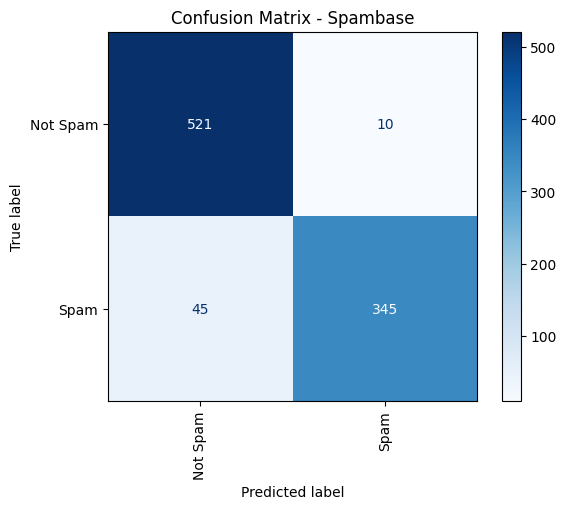

100%|██████████| 1/1 [00:00<00:00, 10.46it/s]

Trial 1/1 - Global test accuracy: 0.9402823018458197


In [16]:
# Parameters
n_trials = 1  # Number of trials
n_trees = 10  # Number of trees in the Random Forest
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

# Training and evaluation loop
for trial in tqdm(range(n_trials)):
    
    # Initialize and train Random Forest
    model = RandomForestClassifier(n_estimators=n_trees, random_state=42 + trial)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Spambase")
    plt.show()
    
    # Append the accuracy to results
    results_global.append(acc_test)
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")


### FL

In [17]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False, random_seed: int = None):
    if shuffle:
        if random_seed is not None:
            np.random.seed(random_seed)
        idx = np.random.permutation(X.shape[0])
        X = X[idx]
        y = y[idx]

    n_entries_per_client = X.shape[0] // n_clients
    partitions = []
    for i in range(n_clients):
        start = i * n_entries_per_client
        end = (i + 1) * n_entries_per_client
        X_i = X[start:end]
        y_i = y[start:end]
        partitions.append((X_i, y_i))
    # Ensure the last partition gets all remaining data.
    partitions[-1] = (X[start:], y[start:])

    return partitions


In [18]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)

In [19]:
# Parameters
max_depth = 10
n_clients = 10
n_trials = 1
random_seed = 42

results = []


# Federated Learning Simulation
for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []

    for i, (X_i, y_i) in enumerate(partitions):
        # Train a DecisionTree model for the client
        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_i, y_i)
        client_models.append(model)

        # Local accuracy on client data
        acc_local = accuracy_score(y_i, model.predict(X_i))
        client_local_accuracies.append(acc_local)

        # Global accuracy on the test set
        acc_global = accuracy_score(y_test, model.predict(X_test))
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations of clients
    n_combinations = 2 ** n_clients
    for i in tqdm(range(1, n_combinations)):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy for the aggregated model
        y_pred_global = forest.predict(X_test)
        acc_global = accuracy_score(y_test, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [client + 1 for client in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]

        results.append(row)

# Save results to CSV
df_results = pd.DataFrame(results)
df_results.to_csv("FedFor Spambase.csv", index=False)


Trial 1/1


100%|██████████| 1023/1023 [00:00<00:00, 1032.58it/s]


In [20]:
df_results = pd.read_csv("FedFor Spambase.csv")

In [21]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
924,1,1110011101,"[1, 3, 4, 5, 8, 9, 10]",0.921824,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
780,1,1100001101,"[1, 3, 4, 9, 10]",0.921824,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
907,1,1110001100,"[3, 4, 8, 9, 10]",0.920738,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
796,1,1100011101,"[1, 3, 4, 5, 9, 10]",0.920738,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
908,1,1110001101,"[1, 3, 4, 8, 9, 10]",0.919653,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849


In [22]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0001000000,1,[7],0.852334
1,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.910966


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.874050                  0.104428
0   Client 1        0.872964                  0.104282
4   Client 5        0.862106                  0.102275
8   Client 9        0.864278                  0.102095
2   Client 3        0.868621                  0.101966
9  Client 10        0.858849                  0.100335
3   Client 4        0.853420                  0.097951
5   Client 6        0.862106                  0.097779
1   Client 2        0.856678                  0.096536
6   Client 7        0.852334                  0.092355


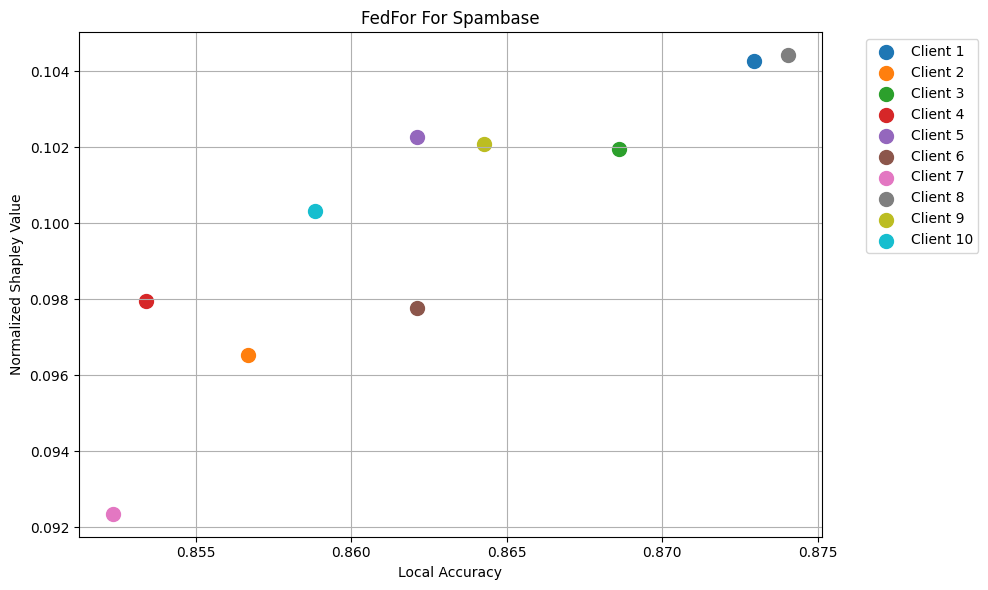

In [23]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="FedFor For Spambase",  
    print_df=True 
)


## Checking Nash For Spambase in 10 and 100 max_depth

In [7]:
# PARAMETERS
n_clients = 10             
n_trials = 10           
base_random_seed = 42     
max_depths = [10, 100]     


all_results = []            
all_nash_equilibrium_counts = [] 
all_nash_details = []            


for max_depth in max_depths:
    print(f"\nRunning experiment with max_depth = {max_depth}")
    

    results = []             
    nash_equilibrium_counts = Counter()
    nash_details_all = []    
    #Run Multiple Trials 
    for trial in range(n_trials):
        print(f"  Trial {trial + 1}/{n_trials} for max_depth = {max_depth}")
        trial_seed = base_random_seed + trial + max_depth
        random.seed(trial_seed)
        np.random.seed(trial_seed)

        target_column = df.columns[-1]
        X = df.drop(target_column, axis=1)
        y = df[target_column]


        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=trial_seed)

        # Convert training and test sets to NumPy arrays (for the split_data_equal function and consistency)
        X_train_np = X_train.to_numpy()
        y_train_np = y_train.to_numpy()
        X_test_np = X_test.to_numpy()
        y_test_np = y_test.to_numpy()
        
        # Split Training Data Equally Among Clients 
        # (Shuffle is True so that every trial gets a different random partition.)
        partitions = split_data_equal(X_train_np, y_train_np, n_clients=n_clients, shuffle=True, random_seed=trial_seed)
        
        #Train Models for Each Client 
        client_models = []
        client_global_accuracies = {}  # Dictionary to store each client's accuracy on the global test set.
        for i, (X_i, y_i) in enumerate(partitions):
            # Train a DecisionTreeClassifier 
            model = DecisionTreeClassifier(max_depth=max_depth, 
                                           random_state=np.random.randint(0, 100000))
            model.fit(X_i, y_i)
            client_models.append(model)
            
            # Evaluate on the global test set 
            y_pred = model.predict(X_test_np)
            acc_global = accuracy_score(y_test_np, y_pred)
            client_global_accuracies[i] = acc_global
        
        
        trial_results = []
        n_combinations = 2 ** n_clients
        for i in tqdm(range(1, n_combinations), desc=f"    Evaluating coalitions for trial {trial + 1}"):
            bin_str = format(i, f'0{n_clients}b')
            coalition_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
            included_models = [client_models[j] for j in coalition_indices]
            if not included_models:
                continue

            forest = FederatedForest()
            for model in included_models:
                forest.add_model(model)
            y_pred_global = forest.predict(X_test_np)
            coalition_acc_global = accuracy_score(y_test_np, y_pred_global)
            

            row = {
                'Trial': trial + 1,
                'Combination': bin_str,
                'Clients': [j + 1 for j in coalition_indices],
                'Global Accuracy': coalition_acc_global
            }

            for j in range(n_clients):
                row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]
            trial_results.append(row)
        

        df_trial_results = pd.DataFrame(trial_results)
        df_trial_results.set_index('Combination', inplace=True)
        
        # Find Nash Equilibria for This Trial
        nash_df = find_nash_equilibria_v2(df_trial_results.reset_index())
        for combination in nash_df['Combination']:
            nash_equilibrium_counts[combination] += 1
        
  
        shapley_df = compute_and_visualize_shapley_values(
            df_trial_results.reset_index(), client_global_accuracies, n_clients=n_clients, plot=False
        )
        shapley_df['Trial'] = trial + 1
        

        for idx, nash_row in nash_df.iterrows():
            combination_bin = nash_row['Combination']
            coalition_indices = [j for j in range(n_clients) if combination_bin[n_clients - 1 - j] == '1']
            clients_list = [j + 1 for j in coalition_indices]
            detail_record = {}
            detail_record['Trial'] = trial + 1
            detail_record['Combination'] = combination_bin
            detail_record['Clients'] = ",".join(str(c) for c in clients_list)
            for client in range(1, n_clients + 1):
                if client in clients_list:
    
                    detail_record[f'Client {client} Accuracy'] = client_global_accuracies[client - 1]
                    val = shapley_df.loc[shapley_df['Client'] == f'Client {client}', 'Normalized Shapley Value']
                    detail_record[f'Client {client} Shapley Value'] = val.values[0] if not val.empty else np.nan
                else:
                    detail_record[f'Client {client} Accuracy'] = np.nan
                    detail_record[f'Client {client} Shapley Value'] = np.nan
            detail_record['Global Accuracy'] = nash_row['Global Accuracy']
            detail_record['Max Depth'] = max_depth
            nash_details_all.append(detail_record)
        

        results.extend(trial_results)
    

    df_results = pd.DataFrame(results)
    df_results['Max Depth'] = max_depth
    all_results.append(df_results)
    

    df_nash_counts = pd.DataFrame(nash_equilibrium_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
    df_nash_counts['Max Depth'] = max_depth
    all_nash_equilibrium_counts.append(df_nash_counts)
    

    filename_counts = f"Nash_Equilibrium_Counts_SpambaseFedFor_max_depth_{max_depth}.csv"
    df_nash_counts.to_csv(filename_counts, index=False)
    print(f"Nash equilibrium counts saved to {filename_counts}")
    

    df_nash_details = pd.DataFrame(nash_details_all)
    all_nash_details.append(df_nash_details)


final_nash_counts_df = pd.concat(all_nash_equilibrium_counts, ignore_index=True)
final_nash_details_df = pd.concat(all_nash_details, ignore_index=True)

final_nash_counts_df.to_csv("Nash_Equilibrium_Counts.csv", index=False)
final_nash_details_df.to_csv("Nash_Equilibrium_Details_SpambaseFedFor.csv", index=False)
print("Process complete. Results saved.")



Running experiment with max_depth = 10
  Trial 1/10 for max_depth = 10


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [00:00<00:00, 1075.22it/s]


      Client  Local Accuracy  Normalized Shapley Value
1   Client 2        0.879479                  0.109773
5   Client 6        0.892508                  0.107297
2   Client 3        0.867535                  0.100955
8   Client 9        0.864278                  0.100602
7   Client 8        0.865364                  0.100453
0   Client 1        0.859935                  0.099673
9  Client 10        0.853420                  0.099566
3   Client 4        0.851249                  0.097659
4   Client 5        0.845820                  0.095400
6   Client 7        0.817590                  0.088621
  Trial 2/10 for max_depth = 10


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [00:00<00:00, 1074.61it/s]


      Client  Local Accuracy  Normalized Shapley Value
0   Client 1        0.881650                  0.104297
1   Client 2        0.878393                  0.103822
6   Client 7        0.880565                  0.102289
4   Client 5        0.872964                  0.102217
2   Client 3        0.877307                  0.102026
5   Client 6        0.874050                  0.100558
7   Client 8        0.862106                  0.098548
8   Client 9        0.861021                  0.096029
3   Client 4        0.855592                  0.095255
9  Client 10        0.864278                  0.094959
  Trial 3/10 for max_depth = 10


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [00:00<00:00, 1082.96it/s]


      Client  Local Accuracy  Normalized Shapley Value
3   Client 4        0.902280                  0.111425
8   Client 9        0.872964                  0.104898
7   Client 8        0.888165                  0.104367
5   Client 6        0.864278                  0.101846
1   Client 2        0.877307                  0.101778
6   Client 7        0.861021                  0.099039
0   Client 1        0.856678                  0.098794
2   Client 3        0.866450                  0.097948
9  Client 10        0.847991                  0.091237
4   Client 5        0.837134                  0.088669
  Trial 4/10 for max_depth = 10


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [00:00<00:00, 1056.41it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.890337                  0.106153
4   Client 5        0.866450                  0.104897
2   Client 3        0.875136                  0.104157
9  Client 10        0.880565                  0.103961
0   Client 1        0.872964                  0.101365
3   Client 4        0.867535                  0.100444
8   Client 9        0.868621                  0.099237
6   Client 7        0.861021                  0.095629
1   Client 2        0.853420                  0.092546
5   Client 6        0.837134                  0.091612
  Trial 5/10 for max_depth = 10


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [00:01<00:00, 1010.52it/s]


      Client  Local Accuracy  Normalized Shapley Value
3   Client 4        0.881650                  0.105517
6   Client 7        0.893594                  0.104878
1   Client 2        0.887079                  0.102479
8   Client 9        0.866450                  0.101441
2   Client 3        0.879479                  0.100378
5   Client 6        0.874050                  0.098392
7   Client 8        0.875136                  0.097694
0   Client 1        0.864278                  0.097240
9  Client 10        0.867535                  0.096130
4   Client 5        0.858849                  0.095851
  Trial 6/10 for max_depth = 10


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [00:00<00:00, 1036.60it/s]


      Client  Local Accuracy  Normalized Shapley Value
5   Client 6        0.876221                  0.109735
8   Client 9        0.864278                  0.103967
9  Client 10        0.867535                  0.102704
6   Client 7        0.872964                  0.101163
7   Client 8        0.868621                  0.100848
3   Client 4        0.855592                  0.098498
1   Client 2        0.857763                  0.098368
2   Client 3        0.858849                  0.098257
0   Client 1        0.852334                  0.093941
4   Client 5        0.851249                  0.092519
  Trial 7/10 for max_depth = 10


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [00:00<00:00, 1043.73it/s]


      Client  Local Accuracy  Normalized Shapley Value
1   Client 2        0.904452                  0.107326
0   Client 1        0.876221                  0.105014
5   Client 6        0.867535                  0.102561
9  Client 10        0.859935                  0.101934
3   Client 4        0.869707                  0.101259
2   Client 3        0.864278                  0.099389
8   Client 9        0.864278                  0.097530
6   Client 7        0.845820                  0.096720
7   Client 8        0.849077                  0.095344
4   Client 5        0.839305                  0.092925
  Trial 8/10 for max_depth = 10


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [00:01<00:00, 984.13it/s]


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.895765                  0.109160
2   Client 3        0.890337                  0.107875
7   Client 8        0.883822                  0.105041
8   Client 9        0.861021                  0.099915
9  Client 10        0.857763                  0.099747
1   Client 2        0.859935                  0.099130
3   Client 4        0.857763                  0.097204
5   Client 6        0.851249                  0.095490
4   Client 5        0.853420                  0.094822
0   Client 1        0.833876                  0.091616
  Trial 9/10 for max_depth = 10


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [00:00<00:00, 1030.88it/s]


      Client  Local Accuracy  Normalized Shapley Value
2   Client 3        0.879479                  0.110446
7   Client 8        0.875136                  0.107805
1   Client 2        0.865364                  0.103411
4   Client 5        0.868621                  0.102122
5   Client 6        0.852334                  0.097876
0   Client 1        0.846906                  0.097733
6   Client 7        0.838219                  0.097029
3   Client 4        0.838219                  0.095783
8   Client 9        0.832790                  0.094479
9  Client 10        0.839305                  0.093316
  Trial 10/10 for max_depth = 10


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [00:00<00:00, 1033.74it/s]


      Client  Local Accuracy  Normalized Shapley Value
3   Client 4        0.897937                  0.109364
6   Client 7        0.888165                  0.106770
8   Client 9        0.887079                  0.106723
9  Client 10        0.889251                  0.106250
7   Client 8        0.872964                  0.096623
1   Client 2        0.859935                  0.096168
0   Client 1        0.852334                  0.095591
4   Client 5        0.858849                  0.094753
2   Client 3        0.861021                  0.094391
5   Client 6        0.852334                  0.093368
Nash equilibrium counts saved to Nash_Equilibrium_Counts_SpambaseFedFor_max_depth_10.csv

Running experiment with max_depth = 100
  Trial 1/10 for max_depth = 100


    Evaluating coalitions for trial 1: 100%|██████████| 1023/1023 [00:01<00:00, 991.41it/s]


      Client  Local Accuracy  Normalized Shapley Value
2   Client 3        0.872964                  0.105158
1   Client 2        0.874050                  0.103478
5   Client 6        0.861021                  0.101243
4   Client 5        0.859935                  0.100764
8   Client 9        0.866450                  0.100215
7   Client 8        0.854506                  0.099077
6   Client 7        0.846906                  0.098429
0   Client 1        0.861021                  0.098218
3   Client 4        0.864278                  0.097536
9  Client 10        0.849077                  0.095881
  Trial 2/10 for max_depth = 100


    Evaluating coalitions for trial 2: 100%|██████████| 1023/1023 [00:01<00:00, 1011.63it/s]


      Client  Local Accuracy  Normalized Shapley Value
8   Client 9        0.884908                  0.108487
6   Client 7        0.878393                  0.106569
2   Client 3        0.870793                  0.102979
7   Client 8        0.861021                  0.101875
0   Client 1        0.856678                  0.101666
5   Client 6        0.849077                  0.097847
9  Client 10        0.852334                  0.096171
4   Client 5        0.852334                  0.096007
3   Client 4        0.840391                  0.095010
1   Client 2        0.849077                  0.093390
  Trial 3/10 for max_depth = 100


    Evaluating coalitions for trial 3: 100%|██████████| 1023/1023 [00:01<00:00, 1003.96it/s]


      Client  Local Accuracy  Normalized Shapley Value
3   Client 4        0.887079                  0.108185
8   Client 9        0.857763                  0.106234
4   Client 5        0.870793                  0.105911
0   Client 1        0.861021                  0.100809
5   Client 6        0.852334                  0.100131
6   Client 7        0.846906                  0.099592
2   Client 3        0.849077                  0.098963
7   Client 8        0.827362                  0.097923
9  Client 10        0.827362                  0.092882
1   Client 2        0.817590                  0.089371
  Trial 4/10 for max_depth = 100


    Evaluating coalitions for trial 4: 100%|██████████| 1023/1023 [00:00<00:00, 1025.99it/s]


      Client  Local Accuracy  Normalized Shapley Value
9  Client 10        0.874050                  0.107652
0   Client 1        0.862106                  0.104692
2   Client 3        0.866450                  0.102796
1   Client 2        0.853420                  0.100412
5   Client 6        0.855592                  0.099981
4   Client 5        0.851249                  0.099671
7   Client 8        0.851249                  0.099498
6   Client 7        0.845820                  0.098303
8   Client 9        0.828447                  0.093734
3   Client 4        0.830619                  0.093261
  Trial 5/10 for max_depth = 100


    Evaluating coalitions for trial 5: 100%|██████████| 1023/1023 [00:01<00:00, 1018.19it/s]


      Client  Local Accuracy  Normalized Shapley Value
0   Client 1        0.864278                  0.105216
4   Client 5        0.878393                  0.104516
1   Client 2        0.875136                  0.103804
2   Client 3        0.872964                  0.101780
6   Client 7        0.882736                  0.101733
5   Client 6        0.870793                  0.099821
7   Client 8        0.858849                  0.099554
8   Client 9        0.853420                  0.096262
9  Client 10        0.837134                  0.094707
3   Client 4        0.844734                  0.092607
  Trial 6/10 for max_depth = 100


    Evaluating coalitions for trial 6: 100%|██████████| 1023/1023 [00:00<00:00, 1027.52it/s]


      Client  Local Accuracy  Normalized Shapley Value
0   Client 1        0.885993                  0.108056
2   Client 3        0.887079                  0.105942
4   Client 5        0.871878                  0.104910
7   Client 8        0.852334                  0.102805
9  Client 10        0.859935                  0.101610
3   Client 4        0.851249                  0.099328
1   Client 2        0.857763                  0.098871
8   Client 9        0.844734                  0.095626
5   Client 6        0.837134                  0.094496
6   Client 7        0.817590                  0.088358
  Trial 7/10 for max_depth = 100


    Evaluating coalitions for trial 7: 100%|██████████| 1023/1023 [00:01<00:00, 1003.42it/s]


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.916395                  0.111303
5   Client 6        0.887079                  0.104644
8   Client 9        0.891422                  0.104400
9  Client 10        0.893594                  0.102570
0   Client 1        0.882736                  0.101051
3   Client 4        0.891422                  0.100205
6   Client 7        0.867535                  0.096712
4   Client 5        0.864278                  0.094466
1   Client 2        0.850163                  0.094016
2   Client 3        0.858849                  0.090634
  Trial 8/10 for max_depth = 100


    Evaluating coalitions for trial 8: 100%|██████████| 1023/1023 [00:01<00:00, 1021.90it/s]


      Client  Local Accuracy  Normalized Shapley Value
3   Client 4        0.896851                  0.111157
6   Client 7        0.877307                  0.106512
1   Client 2        0.875136                  0.101241
5   Client 6        0.865364                  0.100248
0   Client 1        0.872964                  0.099694
4   Client 5        0.864278                  0.097729
9  Client 10        0.855592                  0.097684
2   Client 3        0.850163                  0.096868
7   Client 8        0.853420                  0.095507
8   Client 9        0.849077                  0.093360
  Trial 9/10 for max_depth = 100


    Evaluating coalitions for trial 9: 100%|██████████| 1023/1023 [00:00<00:00, 1025.93it/s]


      Client  Local Accuracy  Normalized Shapley Value
1   Client 2        0.878393                  0.105558
6   Client 7        0.884908                  0.105544
3   Client 4        0.874050                  0.104100
5   Client 6        0.863192                  0.101528
8   Client 9        0.849077                  0.100585
4   Client 5        0.839305                  0.100355
2   Client 3        0.859935                  0.098671
0   Client 1        0.845820                  0.097470
7   Client 8        0.853420                  0.095275
9  Client 10        0.827362                  0.090914
  Trial 10/10 for max_depth = 100


    Evaluating coalitions for trial 10: 100%|██████████| 1023/1023 [00:01<00:00, 1008.20it/s]


      Client  Local Accuracy  Normalized Shapley Value
1   Client 2        0.881650                  0.106074
8   Client 9        0.882736                  0.106021
3   Client 4        0.876221                  0.101737
5   Client 6        0.869707                  0.100831
4   Client 5        0.853420                  0.100576
6   Client 7        0.863192                  0.099292
0   Client 1        0.868621                  0.099158
2   Client 3        0.858849                  0.099084
9  Client 10        0.844734                  0.094180
7   Client 8        0.840391                  0.093046
Nash equilibrium counts saved to Nash_Equilibrium_Counts_SpambaseFedFor_max_depth_100.csv
Process complete. Results saved.
